In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
ads_data = pd.read_csv('../data/ads_data.csv.zip', parse_dates=['date'], compression='zip') # прочитать единственный файл в архиве

In [4]:
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

In [5]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41,2019-04-01 16:24:26
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898,2019-04-01 16:24:26
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29,2019-04-01 16:24:26


### 1. Получить статистику по дням.
Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

<Axes: xlabel='date'>

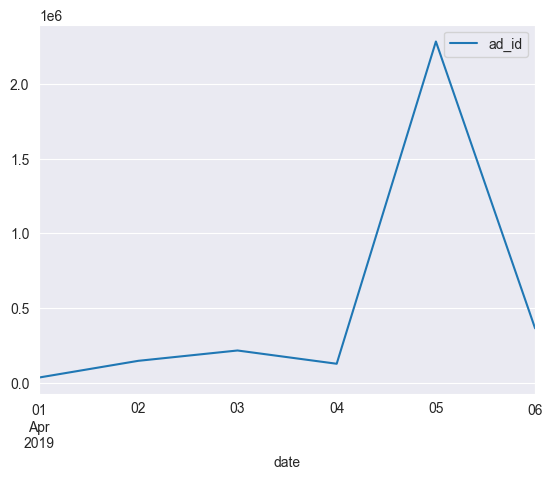

In [6]:
ads_data\
    .groupby('date') \
    .agg({'ad_id': 'count'}).plot()

In [7]:
# ??pd.pivot

In [8]:
ads_data\
    .groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='date', columns='event', values='ad_id')\
    .reset_index()

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [9]:
ads_data\
    .groupby(['date'], as_index=False) \
    .agg({'ad_id': pd.Series.nunique, 'campaign_union_id': pd.Series.nunique})

,date,ad_id,campaign_union_id
0,2019-04-01,49,49
1,2019-04-02,146,146
2,2019-04-03,179,177
3,2019-04-04,150,147
4,2019-04-05,131,130
5,2019-04-06,61,60


### 2. Разобраться, почему случился такой скачок 2019-04-05?
Каких событий стало больше?
У всех объявлений или только у некоторых?

In [10]:
ads_data[ads_data.date == '2019-04-05'] \
    .groupby('ad_id') \
    .agg({'time': 'count'}) \
    .sort_values('time', ascending=False) \
    .head()

,time
ad_id,
112583,2166611
29927,27186
44635,8268
46583,7327
44956,5656


In [11]:
ad_id = 112583

In [12]:
ads_data.query('ad_id == @ad_id').groupby('date').agg({'time': 'count'})

,time
date,
2019-04-05,2166611
2019-04-06,348613


In [13]:
ads_data.query('ad_id == @ad_id').head(1)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
527124,112583,1554480636,view,2019-04-05,CPM,0,111818,112260,web,199.4,239408,4355,2019-04-05 16:10:36


Вывод: только ad_id = 112583 вызвал всплеск просмотров view 2019-04-05.

---
### 3. Найти топ 10 объявлений по CTR за все время.
        CTR — это отношение всех просмотров объявления к кликам.
Различается ли средний и медианный CTR объявлений в наших данных?

In [14]:
ads_data_by_ad = ads_data\
                        .groupby(['ad_id', 'event'], as_index=False) \
                        .agg({'time': 'count'}) \
                        .pivot(index='ad_id', columns='event', values='time')\
                        .reset_index()

ads_data_by_ad.head()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0


In [15]:
ads_data_by_ad = ads_data_by_ad.assign(
                                        ctr = ads_data_by_ad.click / ads_data_by_ad.view,
                                        ctr_per = ads_data_by_ad.click / ads_data_by_ad.view * 100
                                        )
ads_data_by_ad.head()

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,NaN,132.0,NaN,NaN
4,2643,3.0,286.0,0.010490,1.048951


In [16]:
ads_data_by_ad.sort_values('ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
289,112583,580436.0,1934788.0,0.300000,29.999979
324,119450,258.0,1254.0,0.205742,20.574163
125,38575,43.0,257.0,0.167315,16.731518
144,40968,29.0,217.0,0.133641,13.364055
207,45642,42.0,344.0,0.122093,12.209302
283,110924,11.0,95.0,0.115789,11.578947
194,45043,28.0,245.0,0.114286,11.428571
96,35034,112.0,997.0,0.112337,11.233701
5,4585,53.0,476.0,0.111345,11.134454
328,120347,236.0,2168.0,0.108856,10.885609


In [17]:
ads_data_by_ad.ctr.mean()

0.020628096080757954

In [18]:
ads_data_by_ad.ctr.median()

0.010753240746688594

<Axes: xlabel='ctr', ylabel='Count'>

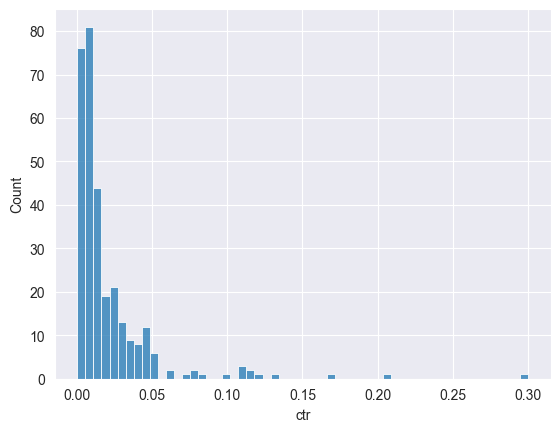

In [19]:
sns.histplot(data=ads_data_by_ad, x='ctr', kde=False)

Вывод: средний показатель выше медианного в 2 раза - происходит из-за перекоса распределения CTR влево (большое количество рекламы с низким CTR и немного с высоким).

---
### 4. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов!
Сколько таких объявлений?
Есть ли какие-то закономерности?
Эта проблема наблюдается на всех платформах?

In [20]:
ads_data_by_ad = ads_data_by_ad.fillna(0)
ads_data_by_ad.head()

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,0.0,132.0,0.000000,0.000000
4,2643,3.0,286.0,0.010490,1.048951


In [21]:
ads_ids_bug = ads_data_by_ad.query('click == 0').ad_id
ads_ids_bug.head()

3      2475
26    16444
29    16678
30    16845
38    20871
Name: ad_id, dtype: int64

In [22]:
ads_bug_by_platform = ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .rename(columns={'ad_id': 'ads_count'})\
    .sort_values('ads_count')

ads_bug_by_platform

,platform,ads_count
2,web,1988
1,ios,3075
0,android,4906


In [23]:
ads_all_by_platform = ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .rename(columns={'ad_id': 'ads_count'})\
    .sort_values('ads_count')

ads_all_by_platform

,platform,ads_count
2,web,635425
1,ios,953078
0,android,1588211


In [24]:
ads_bug_by_platform['percentage'] = ads_bug_by_platform.ads_count / ads_all_by_platform.ads_count * 100
ads_bug_by_platform

,platform,ads_count,percentage
2,web,1988,0.312861
1,ios,3075,0.322639
0,android,4906,0.308901


Вывод: примерно 0,3 % объявлений с багом на каждой платформе.

---
### 5. Есть ли различия в CTR у объявлений с видео и без?


In [25]:
ads_data_by_ad_with_video = ads_data_by_ad.merge(ads_data[['ad_id', 'has_video']], on='ad_id', how='left')
ads_data_by_ad_with_video

,ad_id,click,view,ctr,ctr_per,has_video
0,3,9.0,490.0,0.018367,1.836735,0
1,3,9.0,490.0,0.018367,1.836735,0
2,3,9.0,490.0,0.018367,1.836735,0
3,3,9.0,490.0,0.018367,1.836735,0
4,3,9.0,490.0,0.018367,1.836735,0
...,...,...,...,...,...,...
3176709,122086,50.0,1999.0,0.025013,2.501251,0
3176710,122086,50.0,1999.0,0.025013,2.501251,0
3176711,122086,50.0,1999.0,0.025013,2.501251,0
3176712,122086,50.0,1999.0,0.025013,2.501251,0


In [26]:
ctr_by_video = ads_data_by_ad_with_video.groupby('has_video')['ctr'].mean().reset_index()
ctr_by_video

,has_video,ctr
0,0,0.240271
1,1,0.002666


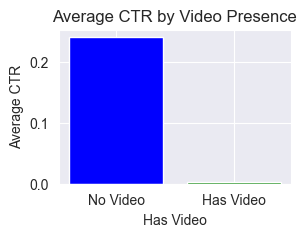

In [27]:
# Построение столбчатой диаграммы
plt.figure(figsize=(3,2))
plt.bar(ctr_by_video['has_video'], ctr_by_video['ctr'], color=['blue', 'green'])
plt.xlabel('Has Video')
plt.ylabel('Average CTR')
plt.title('Average CTR by Video Presence')
plt.xticks(ticks=ctr_by_video['has_video'], labels=['No Video', 'Has Video'])
plt.show()

Вывод: CTR рекламы без видео гораздо выше, чем с ним.

---
### 6. Чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?


In [28]:
df_2019_04_04 =  ads_data[ads_data.date == '2019-04-04']\
                                                        .groupby(['ad_id', 'event'], as_index=False) \
                                                        .agg({'time': 'count'}) \
                                                        .pivot(index='ad_id', columns='event', values='time')\
                                                        .reset_index() \
                                                        .fillna(0)

df_2019_04_04.head()

event,ad_id,click,view
0,9071,3.0,352.0
1,9776,37.0,1115.0
2,10601,3.0,848.0
3,11887,151.0,8720.0
4,12137,1.0,170.0


In [29]:
df_2019_04_04['ctr'] = df_2019_04_04.click / df_2019_04_04.view

In [30]:
df_2019_04_04[df_2019_04_04.click > 0].ctr.quantile(q=0.95)

0.10211538461538454

---
### 7. Для финансового отчета нужно рассчитать заработок по дням.
        Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена - 200 рублей, то за один показ мы зарабатываем 200 / 1000.

В какой день мы заработали больше всего?
В какой меньше?

In [31]:
# Расчет CPC заработка по дням
cpc_daily = ads_data[(ads_data['ad_cost_type'] == 'CPC') & (ads_data['event'] == 'click')]
# cpc_daily = ads_data.query("ad_cost_type == 'CPC' and event == 'click'")

cpc_daily.head(2)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
248,4585,1554135960,click,2019-04-01,CPC,0,37,4382,android,53.5,327648,538,2019-04-01 16:26:00
880,120444,1554136218,click,2019-04-01,CPC,0,120413,120440,android,52.0,4667,874,2019-04-01 16:30:18


In [32]:
cpc_cost_daily = cpc_daily\
                            .groupby('date')['ad_cost']\
                            .sum()\
                            .reset_index(name='cpc_cost')

cpc_cost_daily

,date,cpc_cost
0,2019-04-01,7036.9
1,2019-04-02,7663.7
2,2019-04-03,38597.2
3,2019-04-04,26878.0
4,2019-04-05,4381.2
5,2019-04-06,253.0


In [33]:
cpm_daily = ads_data.query("ad_cost_type == 'CPM' and event == 'view'")
cpm_daily.head(2)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26


In [34]:
cpm_cost_daily = cpm_daily\
                            .groupby('date')\
                            .apply(lambda x: x['ad_cost'].sum() / 1000)\
                            .reset_index(name='cpm_cost')

cpm_cost_daily

,date,cpm_cost
0,2019-04-01,6122.8123
1,2019-04-02,26173.3051
2,2019-04-03,34612.3170
3,2019-04-04,19416.3568
4,2019-04-05,354178.5490
5,2019-04-06,56587.3376


In [35]:
combined_daily_costs = pd.merge(cpc_cost_daily, cpm_cost_daily, on='date', how='outer').sort_values(by='date')
combined_daily_costs['total_daily_cost'] = combined_daily_costs.cpc_cost + combined_daily_costs.cpm_cost
combined_daily_costs

,date,cpc_cost,cpm_cost,total_daily_cost
0,2019-04-01,7036.9,6122.8123,13159.7123
1,2019-04-02,7663.7,26173.3051,33837.0051
2,2019-04-03,38597.2,34612.3170,73209.5170
3,2019-04-04,26878.0,19416.3568,46294.3568
4,2019-04-05,4381.2,354178.5490,358559.7490
5,2019-04-06,253.0,56587.3376,56840.3376


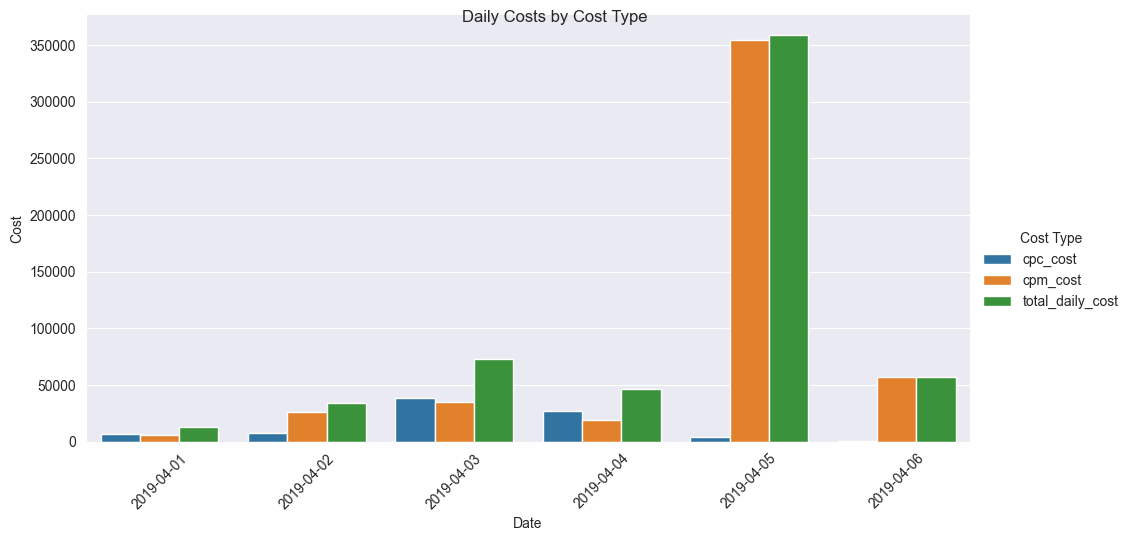

In [36]:
# Построение графика с использованием catplot для группировки по датам
# Сначала преобразуем данные для catplot, "расплавив" столбцы затрат в длинный формат
melted_costs = pd.melt(combined_daily_costs, id_vars='date', value_vars=['cpc_cost', 'cpm_cost', 'total_daily_cost'],
                       var_name='Cost Type', value_name='Cost')

# Использование catplot для создания графика
g = sns.catplot(x='date', y='Cost', hue='Cost Type', data=melted_costs, kind='bar', height=5, aspect=2)

# Настройка параметров отображения
g.fig.suptitle('Daily Costs by Cost Type')
g.set_xticklabels(rotation=45)
g.set_axis_labels("Date", "Cost")

# Отображение графика
plt.show()

Вывод:
- меньше всего заработали 2019-04-01
- больше всего заработали 2019-04-05 (за счет CPC)

---
### 8. Какая платформа самая популярная для размещения рекламных объявлений?


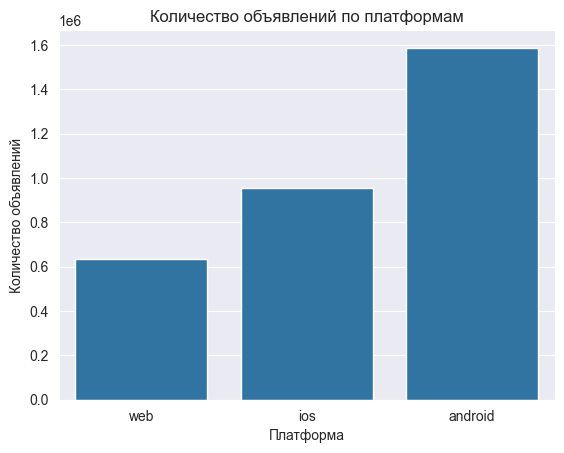

In [37]:
sns.barplot(data=ads_all_by_platform, x='platform', y='ads_count')

# Добавляем название графика и подписи осей
plt.title('Количество объявлений по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество объявлений')

# Отображаем график
plt.show()

---
### 9. Сколько процентов показов приходится на каждую из платформ?

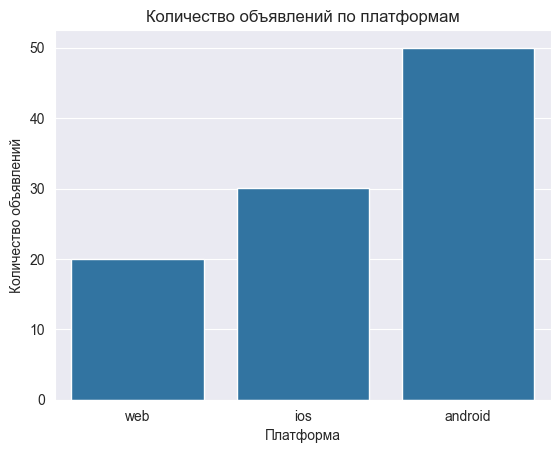

In [38]:
y = (ads_all_by_platform.ads_count / ads_all_by_platform.ads_count.sum()) * 100
sns.barplot(data=ads_all_by_platform, x='platform', y=y)

# Добавляем название графика и подписи осей
plt.title('Количество объявлений по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество объявлений')

# Отображаем график
plt.show()

---
 ### 10. А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?

In [39]:
bug_ads = ads_data\
                    .groupby(['ad_id', 'event'], as_index=False) \
                    .agg({'time': 'min'}) \
                    .pivot(index='ad_id', columns='event', values='time').reset_index() \
                    .query('click < view')
bug_ads

event,ad_id,click,view
27,16548,1.554336e+09,1.554336e+09
81,30939,1.554165e+09,1.554173e+09
138,40464,1.554164e+09,1.554164e+09
158,42007,1.554423e+09,1.554423e+09
185,44543,1.554336e+09,1.554337e+09
201,45436,1.554336e+09,1.554336e+09
324,119450,1.554336e+09,1.554336e+09


In [40]:
ads_data[ads_data.ad_id == 16548].sort_values('time')

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
512690,16548,1554336083,click,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4133,2019-04-04 00:01:23
511482,16548,1554336278,view,2019-04-04,CPM,0,722,16523,android,196.6,53199,3736,2019-04-04 00:04:38
511439,16548,1554336352,view,2019-04-04,CPM,0,722,16523,android,196.6,53199,4968,2019-04-04 00:05:52
511438,16548,1554336352,view,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4206,2019-04-04 00:05:52
511437,16548,1554336352,view,2019-04-04,CPM,0,722,16523,web,196.6,53199,3898,2019-04-04 00:05:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056433,16548,1554422265,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,3613,2019-04-04 23:57:45
2056432,16548,1554422265,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,6044,2019-04-04 23:57:45
2056461,16548,1554422308,view,2019-04-05,CPM,0,722,16523,ios,196.6,53199,5831,2019-04-04 23:58:28
2056652,16548,1554422338,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,2837,2019-04-04 23:58:58


In [41]:
bug_ads.ad_id.to_list()

[16548, 30939, 40464, 42007, 44543, 45436, 119450]

Вывод: [16548, 30939, 40464, 42007, 44543, 45436, 119450] - список объявлений, где клик был до показа.

### 11) Имеются следующие данные о транзакциях в период с 01.12.2010 по 12.09.2011:

            InvoiceNo – номер транзакции
            StockCode – код товара
            Description – описание товара
            Quantity – количество единиц товара, добавленных в заказ
            InvoiceDate – дата транзакции
            UnitPrice – цена за единицу товара
            CustomerID – id клиента
            Country – страна, где проживает клиент

Импортируйте данные data.csv.zip (в папке) с кодировкой ISO-8859-1. Запишите полученный датафрейм в retail, а названия колонок сохраните в переменную retail_columns.

In [34]:
retail = pd.read_csv('https://stepik.org/media/attachments/lesson/361623/data.csv.zip', encoding='ISO-8859-1')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 12) Проверьте, встречаются ли в данных повторяющиеся наблюдения, и в качестве ответа укажите их количество.
Если они есть, то удалите их из retail.


In [35]:
nrows_original = retail.shape[0]

In [36]:
retail.duplicated().all()

False

In [37]:
retail.drop_duplicates(inplace=True)

In [38]:
print(f'Было удалено {nrows_original-retail.shape[0]} дубликатов.')

Было удалено 5268 дубликатов.


### 13) Данные содержат в себе записи как и об успешных транзакциях, так и об отмененных.

            Если пользователь отменил заказ, в начале номера транзакции (InvoiceNo) ставится C (canceled).

   Сколько всего заказов отменили пользователи?

In [39]:
num_retail_no_cancel = retail.InvoiceNo.str.startswith('C').sum()

In [40]:
f"Отменили {num_retail_no_cancel} заказов."

'Отменили 9251 заказов.'

### 14) Теперь отфильтруйте данные и оставьте в retail только те заказы, где Quantity > 0.

In [42]:
retail_no_cancel_and_positive_quantity = retail.query('Quantity>0 and not InvoiceNo.str.startswith("C")')
retail_no_cancel_and_positive_quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### 15) Посчитайте число заказов для каждого пользователя (CustomerID) из Германии (Germany).
Оставьте только тех, кто совершил более N транзакций (InvoiceNo), где N – 80% процентиль.
Запишите полученные id пользователей в germany_top (не весь датафрейм, только id).

        Идентификатор заказа – InvoiceNo. Для каждого заказа в данных может встречаться более 1 строки.

In [48]:
germany_top_df = retail_no_cancel_and_positive_quantity\
                                                    .query('Country == "Germany"')\
                                                    .groupby('CustomerID',as_index=False)\
                                                    .agg({'InvoiceNo': pd.Series.nunique})\
                                                    .rename(columns={'InvoiceNo':'orders_num'})
germany_top_df.head(3)

,CustomerID,orders_num
0,12426.0,1
1,12427.0,3
2,12468.0,2


In [49]:
germany_top_df.orders_num.sort_values().iloc[germany_top_df.shape[0]//2]

3

In [50]:
german_top_percentile_80 = germany_top_df.orders_num.quantile(q=0.8)
german_top_percentile_80

7.0

In [51]:
germany_top = germany_top_df.query('orders_num > @german_top_percentile_80').CustomerID.tolist()
print(germany_top)

[12471.0, 12474.0, 12476.0, 12481.0, 12500.0, 12524.0, 12569.0, 12600.0, 12619.0, 12621.0, 12626.0, 12647.0, 12662.0, 12705.0, 12708.0, 12709.0, 12712.0, 12720.0]


### 16) Используя объект с id пользователей (germany_top), полученный на предыдущем шаге, отфильтруйте наблюдения и оставьте в данных записи только по интересующим нас юзерам.
Результирующий датафрейм запишите в top_retail_germany.

In [54]:
top_retail_germany = retail_no_cancel_and_positive_quantity.query('CustomerID in @germany_top')
top_retail_germany.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,12/1/2010 13:04,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,12/1/2010 13:04,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,12/1/2010 13:04,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662.0,Germany


### 17) Сгруппируйте top_retail_germany по коду товара (StockCode).
Какой из продуктов добавляли в корзину чаще всего, кроме POST?

            Note: одним заказом считается единовременная покупка любого количества товара, т.е. без учета Quantity.


In [67]:
top_retail_germany.StockCode.value_counts().index[1]
# (top_retail_germany
#                     .groupby('StockCode')
#                     .agg({'Quantity': 'count'})
#                     .sort_values(by='Quantity', ascending=False)
#                     .index[1]
# )

'22326'

### 18) Вернемся к анализу полного датасета retail_no_cancel_and_positive_quantity.
Создайте колонку Revenue с суммой покупки, используя колонки Quantity и UnitPrice.

In [73]:
#retail_no_cancel_and_positive_quantity['Revenue'] = retail_no_cancel_and_positive_quantity.Quantity * retail_no_cancel_and_positive_quantity.UnitPrice
retail_no_cancel_and_positive_quantity = retail_no_cancel_and_positive_quantity.assign(
    Revenue = retail_no_cancel_and_positive_quantity.Quantity * retail_no_cancel_and_positive_quantity.UnitPrice
)

### 19) Для каждой транзакции (InvoiceNo), посчитайте финальную сумму заказа.
В качестве ответа укажите топ-5 (InvoiceNo) по сумме заказа (через запятую с пробелом и в порядке убывания TotalRevenue)

   Например, для следующего примера...

            InvoiceNo StockCode Quantity InvoiceDate          UnitPrice  CustomerID  Revenue
            536365    85123A    6        2010-12-01 08:26:00  2.55       17850.0     15.30
            536365    71053     6        2010-12-01 08:26:00  3.39       17850.0     20.34
            555555    71053     1        2010-12-02 18:00:00  3.39       17850.0     3.39
   ...сумма заказа будет равна:

            InvoiceNo  TotalRevenue
            536365     35.64
            555555     3.39

In [85]:
top_5 = retail_no_cancel_and_positive_quantity.groupby('InvoiceNo', as_index=False).agg({'Revenue': 'sum'}).rename(columns={'Revenue': 'TotalRevenue'}).sort_values(by='TotalRevenue', ascending=False)
top_5

,InvoiceNo,TotalRevenue
20689,581483,168469.60
2202,541431,77183.60
17582,574941,52940.94
18251,576365,50653.91
9034,556444,38970.00
...,...,...
10074,558724,0.00
10075,558725,0.00
10150,558889,0.00
20726,A563186,-11062.06


In [90]:
answer = top_5.InvoiceNo[:5].str.cat(sep=', ')
f"Список ID самых дорогостоящих покупок: {answer}."

'Список ID самых дорогостоящих покупок 581483, 541431, 574941, 576365, 556444.'

---
Баганные данные ниже

In [80]:
retail_no_cancel_and_positive_quantity.query('InvoiceNo == "A563187"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom,-11062.06


In [81]:
retail_no_cancel_and_positive_quantity.query('InvoiceNo == "558343"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
242438,558343,84709B,NaN,6,6/28/2011 14:44,0.0,NaN,United Kingdom,0.0
